# 导包

In [1]:
#导包
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,Multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
# calculate RMSE
from tensorflow.keras.losses import MeanSquaredError
from math import sqrt
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os 
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用 GPU 1
# from model import create_model
from evaluate import look_loss
from evaluate import all_estimate

gc.collect()

2025-04-21 11:20:10.114316: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 11:20:10.162246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745205610.198880  332270 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745205610.207996  332270 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745205610.248339  332270 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

23

# 数据处理

In [ ]:
depth = [5.1, 18.5, 40.3, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4]
data_st_processed = np.load(r'./data_st_processed.npy')
data_surface_processed = np.load(r'./data_surface_processed.npy')
data_surface = data_surface_processed

data_input = data_surface

data_st = data_st_processed[0:132,:,:,:]
data_underwater1 = np.load(r'./with_noise/rate95_5/layer1_pred_data.npy')
data_underwater2 = np.load(r'./with_noise/rate95_5/layer2_pred_data.npy')
data_underwater3 = np.load(r'./with_noise/rate95_5/layer3_pred_data.npy')
data_underwater4 = np.load(r'./with_noise/rate95_5/layer4_pred_data.npy')
data_underwater5 = np.load(r'./with_noise/rate95_5/layer5_pred_data.npy')
data_underwater6 = np.load(r'./with_noise/rate95_5/layer6_pred_data.npy')
data_underwater7 = np.load(r'./with_noise/rate95_5/layer7_pred_data.npy')
data_underwater8 = np.load(r'./with_noise/rate95_5/layer8_pred_data.npy')
data_underwater = np.concatenate((data_underwater1, data_underwater2,data_underwater3,data_underwater4,data_underwater5,data_underwater6,data_underwater7,data_underwater8), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[:,:,:,8:9] #(132,  100，160， 1)
print(out_data_y.shape)

(132, 108, 168, 5) (132, 100, 160, 20)
(132, 100, 160, 1)


In [3]:
print('----------------for layer9_ST--------------------')

time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

----------------for layer9_ST--------------------
(132, 100, 160, 9, 9, 13)


In [4]:
# 修改变量形状
out_data_reshape = out_data.reshape((132,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)
    

(132, 16000, 9, 9, 13)
(132, 16000, 9, 9, 13)
(16000, 81)


In [5]:
out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
print('out_data_y_reshape:',out_data_y_reshape.shape)
out_data_y_reshape = out_data_y_reshape.reshape(-1,132,1)
print('out_data_y_reshape:',out_data_y_reshape.shape)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)
    

out_data_reshape: (16000, 132, 9, 9, 13)
out_data_y_reshape: (100, 160, 132, 1)
out_data_y_reshape: (16000, 132, 1)


In [6]:
print(nan_mask2)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [7]:
nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]


In [8]:
out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

In [9]:
out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)

# 最后十二个月的数据作为test
test_num = 120
x_train = out_data_reshape[:test_num]
y_train = out_data_y_reshape[:test_num]

x_test = out_data_reshape[test_num:]
y_test = out_data_y_reshape[test_num:]

# 将前两个维度进行合并  时间*(lat*lon)
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))

y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=100)

out_data_reshape: (132, 14783, 9, 9, 13)
out_data_y_reshape: (132, 14783, 1)


In [10]:
# 记录数据集的形状
x_train_shape = x_train.shape
y_train_shape = y_train.shape

x_test_shape = x_test.shape
y_test_shape = y_test.shape

x_val_shape = x_val.shape
y_val_shape = y_val.shape


In [11]:
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train_shape[3])) 
x_test = scaler_f.transform(x_test.reshape(-1,x_test_shape[3]))
x_val = scaler_f.transform(x_val.reshape(-1,x_val_shape[3]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,y_train_shape[1])) 
y_test = scaler_l.transform(y_test.reshape(-1,y_test_shape[1])) 
y_val = scaler_l.transform(y_val.reshape(-1,y_val_shape[1])) 

In [12]:
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))
x_val = np.reshape(x_val,(-1,9,9,channel))
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))
y_val = np.reshape(y_val,(-1,1))

# 模型训练

# 无注意力机制

In [13]:
# 使用自定义注意力层
def create_model(neurons1, neurons2):
    # 第一部分输入
    model_input = Input(shape=x_train.shape[1:3] + (5,))
    x = Conv2D(filters=neurons1, kernel_size=(3, 3), strides=1)(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv2D(filters=neurons2, kernel_size=(3, 3), strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Flatten()(x)
    x = Dense(units=64, activation='relu')(x)
    # x = Dense(units=16, activation='relu')(x)

    # 第二部分输入
    model_input2 = Input(shape=x_train.shape[1:3] + (8,))


    # 第二部分卷积网络
    x1 = Conv2D(filters=32, kernel_size=(3, 3), strides=1)(model_input2)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Conv2D(filters=64, kernel_size=(3, 3), strides=1)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Flatten()(x1)
    x1 = Dense(units=8, activation='relu')(x1)
    # x1 = Dense(units=16, activation='relu')(x1)
    
    # 正确写法（方法1）
    concatenated = Concatenate(axis=-1)([
        Lambda(lambda x: 0.95 * x)(x),
        Lambda(lambda x: 0.05 * x)(x1)
    ])

    # 后续层
    # concatenated = Dense(32, activation='relu')(concatenated)
    concatenated = Dense(units=32, activation='relu')(concatenated)
    concatenated = Dense(units=16, activation='relu')(concatenated)
    

    # # 输出层
    out = Dense(units=1)(concatenated)
    
    # out = Dense(units=1)(x1)
    

    # 创建模型
    model = Model(inputs=[model_input, model_input2], outputs=out)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# 创建模型
model = create_model(128, 256)

# 回调函数
checkpoint_path = 'layer9_no_95_5/CNN_model_layer9_st_no.keras'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


# 训练模型
num_epochs = 200
batch_size = 2048
# history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:14]], y_train,
                    # validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:14]], y_val),
                    # epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=[keras_callbacks, OutputCallback()])
                    
history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:13]], y_train,
                    validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:13]], y_val),
                    epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=keras_callbacks)

I0000 00:00:1745205790.428638  332270 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9


Epoch 1/200


I0000 00:00:1745205825.449470  332584 service.cc:152] XLA service 0x7fc1bc003af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745205825.449639  332584 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-21 11:23:45.704868: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745205826.497585  332584 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-21 11:23:49.951527: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3489', 144 bytes spill stores, 144 bytes spill loads

2025-04-21 11:23:50.055299: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

607/607 - 60s - 100ms/step - loss: 0.0381 - val_loss: 0.0156
Epoch 2/200
607/607 - 19s - 31ms/step - loss: 0.0141 - val_loss: 0.0106
Epoch 3/200
607/607 - 19s - 31ms/step - loss: 0.0121 - val_loss: 0.0091
Epoch 4/200
607/607 - 18s - 30ms/step - loss: 0.0115 - val_loss: 0.0093
Epoch 5/200
607/607 - 18s - 30ms/step - loss: 0.0111 - val_loss: 0.0136
Epoch 6/200
607/607 - 19s - 31ms/step - loss: 0.0112 - val_loss: 0.0087
Epoch 7/200
607/607 - 19s - 31ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 8/200
607/607 - 19s - 30ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 9/200
607/607 - 19s - 31ms/step - loss: 0.0106 - val_loss: 0.0086
Epoch 10/200
607/607 - 18s - 30ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 11/200
607/607 - 19s - 31ms/step - loss: 0.0102 - val_loss: 0.0084
Epoch 12/200
607/607 - 19s - 31ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 13/200
607/607 - 19s - 31ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 14/200
607/607 - 18s - 30ms/step - loss: 0.0100 - val_loss: 0.010

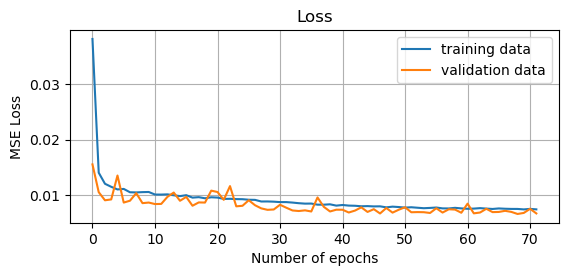

5544/5544 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step
Test RMSE: 0.221
acc: 97.534035
R² score: 0.9505779147148132


In [14]:
look_loss(history)
best_model1 = tf.keras.models.load_model('layer9_no_95_5/CNN_model_layer9_st_no.keras',      safe_mode=False)
all_estimate(best_model1,[x_test[:,:,:,0:5], x_test[:,:,:,5:13]], y_test)#x_test[:,:,:,0:5], x_test[:,:,:,5:13], y_test

In [15]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer9_no_95_5/CNN_model_layer9_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:13]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer9_st = scaler_l.inverse_transform(result)
y_test_layer9_unscaled = scaler_l.inverse_transform(y_test)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step


In [16]:
r2 = r2_score(y_test_layer9_unscaled[:,0],predict_layer9_st[:,0])
print('layer9 R² score:',r2)
mae =  np.mean(np.sqrt(np.square(y_test_layer9_unscaled[:,0]-predict_layer9_st[:,0])))
print('layer9 Test mae: %.3f' % mae)

layer9 R² score: 0.950577974319458
layer9 Test mae: 0.671


Results written to results.txt
[[23.24595833 23.35953712 23.31561661 ... 22.34954453 22.43990898
  22.4802742 ]
 [23.32848549 23.26409912 23.21061325 ... 22.61506271 22.65414238
  22.79520226]
 [23.2323494  23.19193077 23.20065308 ... 22.85407639 22.87731171
  22.77624893]
 ...
 [ 8.53826046  8.4949379   8.82823944 ... 13.57074928 13.45466518
  13.36101532]
 [ 7.74740744  7.42742968  7.81407213 ... 12.75368309 12.69091225
  12.44952679]
 [        nan         nan  5.29888201 ... 11.31039619 11.0868845
  10.66994667]]


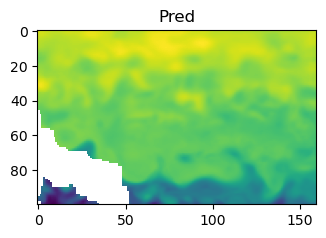

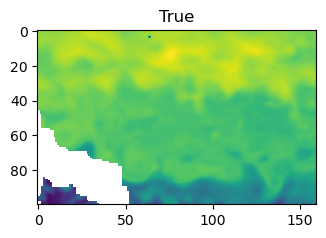

[[21.70461082 21.76686859 21.8005619  ... 21.11938858 21.32447243
  21.55519295]
 [21.96316338 22.00784302 22.01296997 ... 21.07251167 21.22779083
  21.5002594 ]
 [22.25540924 22.29349709 22.27957916 ... 21.04980659 21.14502335
  21.33545876]
 ...
 [ 6.46244669  6.0141902   6.30130911 ... 13.3591423  13.50856018
  13.52906895]
 [ 4.24533796  3.90475035  3.98019361 ... 12.51609898 12.69408226
  12.7204504 ]
 [        nan         nan  1.97695875 ... 11.42548943 11.4379406
  11.34858227]]


7838

In [17]:
predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer9_st
true_data[non_nan_mask] = y_test_layer9_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer9_no_95_5/results.txt", "w") as file:
    file.write(f"layer9 R² score: {r2}\n")
    file.write(f"layer9 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer9_no_95_5/predict_data.npy',predict_data)
np.save(r'./layer9_no_95_5/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()